# import stuff

In [3]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import glob
import netCDF4
import pandas
import wrf
import string
import seaborn
import matplotlib.colors
import cmocean
import matplotlib.cm

import metpy
import metpy.plots
import metpy.calc
import metpy.units

import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

# set up wet and dry regions

In [4]:
dry_lon_lo, dry_lon_hi, dry_lat_lo, dry_lat_hi = -60,-50,-10,10
wet_lon_lo, wet_lon_hi, wet_lat_lo, wet_lat_hi = -80,-75,-10,10

dry_lon_lo_degE = 360+dry_lon_lo
dry_lon_hi_degE = 360+dry_lon_hi

wet_lon_lo_degE = 360+wet_lon_lo
wet_lon_hi_degE = 360+wet_lon_hi

In [5]:
lon_lo = dry_lon_lo
lon_hi = dry_lon_hi
lat_lo = dry_lat_lo
lat_hi = dry_lat_hi

# lon_lo = wet_lon_lo
# lon_hi = wet_lon_hi
# lat_lo = wet_lat_lo
# lat_hi = wet_lat_hi

# open control data

In [6]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/400/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [7]:
cont_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [8]:
ptot_400 = numpy.load('DATA_ptot_400.npy')
geopot_400 = numpy.load('DATA_geopot_400.npy')
#cape3d_400 = numpy.load('DATA_cape3d_400.npy')
#cape2d_400 = numpy.load('DATA_cape2d_400.npy')
td_400 = numpy.load('DATA_td_400.npy')
tk_400 = numpy.load('DATA_tk_400.npy')

In [9]:
hgt = cont_mfds['HGT'].sel(Time=0).values

In [10]:
time = cont_mfds['Times'].values
xlat = cont_mfds['XLAT'].values[0,:,:]
xlong = cont_mfds['XLONG'].values[0,:,:]
landmask = cont_mfds['LANDMASK'].values[0,:,:]
landmask_midpoints = landmask[1:,1:]

In [11]:
landmask_indices = numpy.copy(landmask)
landmask_indices[landmask==1]=1
landmask_indices[landmask!=1]=0
landmask_indices = numpy.array(landmask_indices, dtype=bool)

In [12]:
lon_indices = (xlong>=lon_lo)&(xlong<=lon_hi)
lat_indices = (xlat>=lat_lo)&(xlat<=lat_hi)
latlon_indices = (lon_indices)&(lat_indices)&(landmask_indices)
latlon_indices_high_andes = (lon_indices)&(lat_indices)&(landmask_indices)&(hgt>1500.)

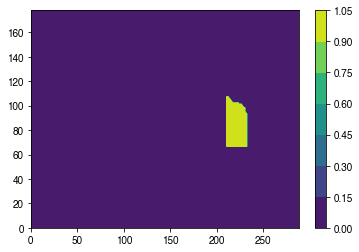

In [13]:
mp.contourf(latlon_indices);mp.colorbar()

# open phys data

In [14]:
root_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/FMAASO/1000/ens_mean_wrfout_files'
file_list = sorted(glob.glob(root_dir+'/'+'wrfout*.nc'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [15]:
phys_mfds = xarray.open_mfdataset(root_dir + '/' + 'wrfout*.nc')

In [16]:
ptot_1000 = numpy.load('DATA_ptot_1000.npy')
#cape3d_1000 = numpy.load('DATA_cape3d_1000.npy')
#cape2d_1000 = numpy.load('DATA_cape2d_1000.npy')
td_1000 = numpy.load('DATA_td_1000.npy')

In [17]:
tk_1000 = numpy.load('DATA_tk_1000.npy')

## calculate from perspective of atmosphere

# calculate area mean net bottom and top diffs

# pressure averages

In [18]:
ptot_latlon_subset_timemean = numpy.mean(ptot_400[:,:,latlon_indices], axis=2).mean(axis=0)

# td diffs

In [19]:
td_400_latlon_subset = td_400[:,:,latlon_indices]
td_1000_latlon_subset = td_1000[:,:,latlon_indices]

td_400_latlon_mean = numpy.nanmean(td_400_latlon_subset, axis=2)
td_1000_latlon_mean = numpy.nanmean(td_1000_latlon_subset, axis=2)

In [20]:
td_400_latlon_alltime = numpy.nanmean(td_400_latlon_subset, axis=(0,2))
td_1000_latlon_alltime = numpy.nanmean(td_400_latlon_subset, axis=(0,2))

# tk diffs

In [21]:
tk_400_latlon_subset = tk_400[:,:,latlon_indices]
tk_1000_latlon_subset = tk_1000[:,:,latlon_indices]

tk_400_latlon_mean = numpy.nanmean(tk_400_latlon_subset, axis=2)
tk_1000_latlon_mean = numpy.nanmean(tk_1000_latlon_subset, axis=2)

In [22]:
tk_400_latlon_alltime = numpy.nanmean(tk_400_latlon_subset, axis=(0,2))
tk_1000_latlon_alltime = numpy.nanmean(tk_1000_latlon_subset, axis=(0,2))

# qvapor diffs

# cape diffs

# plot skew T

In [23]:
metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                  (tk_400_latlon_alltime[:]-273.15)*metpy.units.units.degC, \
                                  (td_400_latlon_alltime[:]-273.15)*metpy.units.units.degC)

(<Quantity(1309.189707336896, 'joule / kilogram')>,
 <Quantity(-32.587760633381635, 'joule / kilogram')>)

# cape calculations

In [24]:
ptot_lo = 100
ptot_hi = 1013.25
hour = 19

ptot_indices = (ptot_latlon_subset_timemean/100.<=ptot_hi)&(ptot_latlon_subset_timemean/100.>=ptot_lo)

cape_400 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_400_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_400_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC)

cape_1000 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_1000_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_1000_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC)

print(cape_400)
print(cape_1000)

(<Quantity(1868.337738514075, 'joule / kilogram')>, <Quantity(-9.753692750808403, 'joule / kilogram')>)
(<Quantity(1474.5984548484685, 'joule / kilogram')>, <Quantity(-6.88662640744702, 'joule / kilogram')>)


3-hour afternoon mean

In [25]:
color_list = [\
matplotlib.cm.tab20c(4/20), \
matplotlib.cm.tab20c(5.5/20), \
matplotlib.cm.tab20c(0/20), \
matplotlib.cm.tab20c(1.5/20) ]

# for first day

Text(0.02,0.02,'CAPE$_{\\,cont}$ = 1276 J kg$^{\\,-1}$\nCAPE$_{\\,phys}$ = 1073 J kg$^{\\,-1}$\nCIN$_{\\,cont}$ = -10 J kg$^{\\,-1}$\nCIN$_{\\,phys}$ = -7 J kg$^{\\,-1}$')

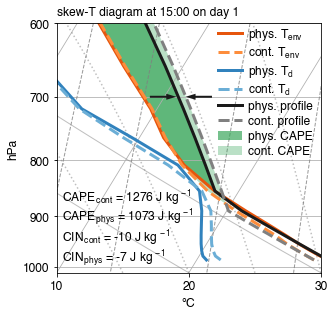

In [26]:
fontsize=12
hour = 19

skewt_plot = metpy.plots.SkewT()

skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_1000_latlon_mean[hour,:]-273.15, lw=3, label='phys. T$_{env}$', c=color_list[0])
skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_400_latlon_mean[hour,:]-273.15, lw=3, label='cont. T$_{env}$', ls='--', c=color_list[1])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_1000_latlon_mean[hour,:]-273.15, lw=3, label='phys. T$_d$', c=color_list[2])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_400_latlon_mean[hour,:]-273.15, lw=3, label='cont. T$_d$', ls='--', c=color_list[3])

pprofile_400 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_400_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC, \
                                         (td_400_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC).to('degC')
pprofile_1000 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_1000_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC, \
                                         (td_1000_latlon_mean[hour,:][0]-273.15)*metpy.units.units.degC).to('degC')

skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_1000, label='phys. profile', c='0.1', lw=3, ls='-')
skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_400, label='cont. profile', c='0.5', lw=3, ls='--')


# fill in control and phys CAPE
skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_1000_latlon_mean[hour,:]-273.15,\
                      numpy.array(pprofile_1000),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.666,\
                      label='phys. CAPE')

skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_400_latlon_mean[hour,:]-273.15,\
                      numpy.array(pprofile_400),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.333,\
                      label='cont. CAPE')

skewt_plot.ax.set_ylim(1013.25,600)
skewt_plot.ax.set_xlim(10,30)

fig = mp.gcf()
fig.set_size_inches(4.45,4.25)
fig.tight_layout()

skewt_plot.ax.tick_params(labelsize=fontsize)
skewt_plot.ax.set_ylabel('hPa', fontsize=fontsize)
skewt_plot.ax.set_xlabel('$\degree$C', fontsize=fontsize)

skewt_plot.plot_dry_adiabats(color='0.5',linewidth=1,linestyle='-')
skewt_plot.plot_moist_adiabats(color='0.5',linestyle=':')
skewt_plot.plot_mixing_lines(color='0.5',linestyle='--',lw=1)

handles, labels = skewt_plot.ax.get_legend_handles_labels()
skewt_plot.ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
                     bbox_to_anchor=(0.6,1.0), \
                     bbox_transform=skewt_plot.ax.transAxes, loc='upper left', \
                     borderaxespad=0, labelspacing=0.25, fancybox=False, \
                     edgecolor='0', framealpha=0, borderpad=0.25, \
                     columnspacing=0.5, handletextpad=0.5, markerscale=1)

skewt_plot.ax.text(s='skew-T diagram at 15:00 on day 1',\
                  x=0,y=1.02,\
                  transform=skewt_plot.ax.transAxes,\
                  ha='left',va='bottom', fontsize=fontsize)

skewt_plot.ax.annotate("",xy=(11.6,700), \
                       xycoords='data',\
                       xytext=(13.6, 700), \
                       textcoords='data',\
                       arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=10))

skewt_plot.ax.annotate("",xy=(10.9,700), \
                       xycoords='data',\
                       xytext=(8.9, 700), \
                       textcoords='data',\
                       arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=10))

ptot_lo = 300
ptot_hi = 1013.25

ptot_indices = (ptot_latlon_subset_timemean/100.<=ptot_hi)&(ptot_latlon_subset_timemean/100.>=ptot_lo)

cape_400 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_400_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_400_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC)

cape_1000 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_1000_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_1000_latlon_mean[hour,ptot_indices]-273.15)*metpy.units.units.degC)

CAPE_CIN_text = 'CAPE$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[0]))+' J kg$^{\,-1}$\n'\
                'CAPE$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[0]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[1]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[1]))+' J kg$^{\,-1}$'
skewt_plot.ax.text(s=CAPE_CIN_text,x=.02,y=0.02,ha='left',va='bottom',\
                   transform=skewt_plot.ax.transAxes,fontsize=fontsize,linespacing=1)

#fig.savefig('../figures/MAIN_fig06.pdf', bbox_inches='tight', transparent=True)

# do for all days (2-10 mean)

In [27]:
time_datetimes = pandas.to_datetime([i.decode('utf-8') for i in time], format = '%Y-%m-%d_%H:%M:%S')
time_datetimes_andes = time_datetimes+datetime.timedelta(hours=-5)
time_datetimes_amazon = time_datetimes+datetime.timedelta(hours=-4)

In [42]:
hour_indices = [t.hour in [15] and t.day in range(2,11) for t in time_datetimes_amazon]

In [43]:
ptot_lo = 100
ptot_hi = 1013.25

tk_400_latlon_afternoon = numpy.nanmean(tk_400_latlon_mean[hour_indices,:], axis=0)
td_400_latlon_afternoon = numpy.nanmean(td_400_latlon_mean[hour_indices,:], axis=0)

tk_1000_latlon_afternoon = numpy.nanmean(tk_1000_latlon_mean[hour_indices,:], axis=0)
td_1000_latlon_afternoon = numpy.nanmean(td_1000_latlon_mean[hour_indices,:], axis=0)

ptot_indices = (ptot_latlon_subset_timemean/100.<=ptot_hi)&(ptot_latlon_subset_timemean/100.>=ptot_lo)

cape_400 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_400_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_400_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC)

cape_1000 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_1000_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_1000_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC)

print(cape_400)
print(cape_1000)

(<Quantity(1952.832754099332, 'joule / kilogram')>, <Quantity(-9.290027078717698, 'joule / kilogram')>)
(<Quantity(1609.3138224378679, 'joule / kilogram')>, <Quantity(-11.52866204839631, 'joule / kilogram')>)


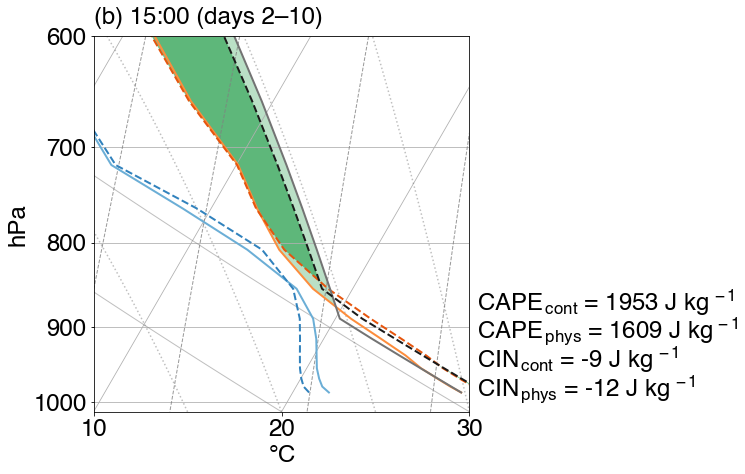

In [44]:
fontsize=24
hour = 19

skewt_plot = metpy.plots.SkewT()


skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_400_latlon_afternoon-273.15, lw=2, label='cont. T$_{env}$', ls='-', c=color_list[1])
skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_1000_latlon_afternoon-273.15, lw=2, label='phys. T$_{env}$', ls='--', c=color_list[0])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_400_latlon_afternoon-273.15, lw=2, label='cont. T$_d$', ls='-', c=color_list[3])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_1000_latlon_afternoon-273.15, lw=2, label='phys. T$_d$', ls='--', c=color_list[2])

pprofile_400 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_400_latlon_afternoon[0]-273.15)*metpy.units.units.degC, \
                                         (td_400_latlon_afternoon[0]-273.15)*metpy.units.units.degC).to('degC')
pprofile_1000 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_1000_latlon_afternoon[0]-273.15)*metpy.units.units.degC, \
                                         (td_1000_latlon_afternoon[0]-273.15)*metpy.units.units.degC).to('degC')

skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_400, label='cont. profile', c='0.45', lw=2, ls='-')
skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_1000, label='phys. profile', c='0.1', lw=2, ls='--')



# fill in control and phys CAPE
skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_400_latlon_afternoon-273.15,\
                      numpy.array(pprofile_400),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.333,\
                      label='cont. CAPE')
skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_1000_latlon_afternoon-273.15,\
                      numpy.array(pprofile_1000),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.666,\
                      label='phys. CAPE')

skewt_plot.ax.set_ylim(1013.25,600)
skewt_plot.ax.set_xlim(10,30)

fig = mp.gcf()
fig.set_size_inches(6,6)
fig.tight_layout()

skewt_plot.ax.tick_params(labelsize=fontsize)
skewt_plot.ax.set_ylabel('hPa', fontsize=fontsize)
skewt_plot.ax.set_xlabel('$\degree$C', fontsize=fontsize)

skewt_plot.plot_dry_adiabats(color='0.5',linewidth=1,linestyle='-')
skewt_plot.plot_moist_adiabats(color='0.5',linestyle=':')
skewt_plot.plot_mixing_lines(color='0.5',linestyle='--',lw=1)

# handles, labels = skewt_plot.ax.get_legend_handles_labels()
# skewt_plot.ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
#                      bbox_to_anchor=(0.625,0.99), \
#                      bbox_transform=skewt_plot.ax.transAxes, loc='upper left', \
#                      borderaxespad=0, labelspacing=0.2, fancybox=False, \
#                      edgecolor='0', framealpha=0, borderpad=0.25, \
#                      columnspacing=0.5, handletextpad=0.5, markerscale=1, handlelength=1.5)

skewt_plot.ax.text(s='(b) 15:00 (days 2–10)',\
                  x=0,y=1.02,\
                  transform=skewt_plot.ax.transAxes,\
                  ha='left',va='bottom', fontsize=fontsize)

# skewt_plot.ax.annotate("",xy=(11.8,700), \
#                        xycoords='data',\
#                        xytext=(13.8, 700), \
#                        textcoords='data',\
#                        arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=9))

# skewt_plot.ax.annotate("",xy=(11.1,700), \
#                        xycoords='data',\
#                        xytext=(9.1, 700), \
#                        textcoords='data',\
#                        arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=9))

CAPE_CIN_text = 'CAPE$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[0]))+' J kg$^{\,-1}$\n'\
                'CAPE$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[0]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[1]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[1]))+' J kg$^{\,-1}$'
skewt_plot.ax.text(s=CAPE_CIN_text,x=1.02,y=0.02,ha='left',va='bottom',\
                   transform=skewt_plot.ax.transAxes,fontsize=fontsize,linespacing=0.9)

fig.savefig('../figures/POSTER_skewT_1500.pdf', bbox_inches='tight', transparent=True)

# now do for 11:00

In [45]:
hour_indices = [t.hour in [11] and t.day in range(2,11) for t in time_datetimes_amazon]

In [46]:
ptot_lo = 100
ptot_hi = 1013.25

tk_400_latlon_afternoon = numpy.nanmean(tk_400_latlon_mean[hour_indices,:], axis=0)
td_400_latlon_afternoon = numpy.nanmean(td_400_latlon_mean[hour_indices,:], axis=0)

tk_1000_latlon_afternoon = numpy.nanmean(tk_1000_latlon_mean[hour_indices,:], axis=0)
td_1000_latlon_afternoon = numpy.nanmean(td_1000_latlon_mean[hour_indices,:], axis=0)

ptot_indices = (ptot_latlon_subset_timemean/100.<=ptot_hi)&(ptot_latlon_subset_timemean/100.>=ptot_lo)

cape_400 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_400_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_400_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC)

cape_1000 = metpy.calc.surface_based_cape_cin(ptot_latlon_subset_timemean[ptot_indices]/100.*metpy.units.units.hPa, \
                                  (tk_1000_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC, \
                                  (td_1000_latlon_afternoon[ptot_indices]-273.15)*metpy.units.units.degC)

print(cape_400)
print(cape_1000)

(<Quantity(1685.3373386627347, 'joule / kilogram')>, <Quantity(4.543057138460284, 'joule / kilogram')>)
(<Quantity(1485.167089243698, 'joule / kilogram')>, <Quantity(7.232288124931445, 'joule / kilogram')>)


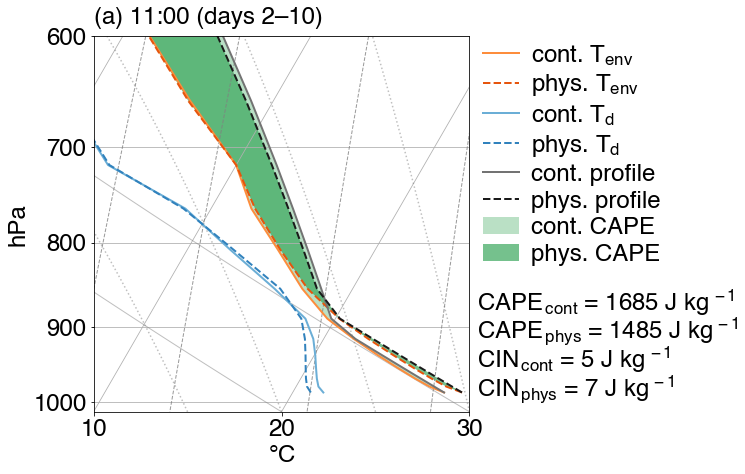

In [48]:
fontsize=24
hour = 19

skewt_plot = metpy.plots.SkewT()


skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_400_latlon_afternoon-273.15, lw=2, label='cont. T$_{env}$', ls='-', c=color_list[1])
skewt_plot.plot(ptot_latlon_subset_timemean/100., tk_1000_latlon_afternoon-273.15, lw=2, label='phys. T$_{env}$', ls='--', c=color_list[0])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_400_latlon_afternoon-273.15, lw=2, label='cont. T$_d$', ls='-', c=color_list[3])
skewt_plot.plot(ptot_latlon_subset_timemean/100., td_1000_latlon_afternoon-273.15, lw=2, label='phys. T$_d$', ls='--', c=color_list[2])

pprofile_400 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_400_latlon_afternoon[0]-273.15)*metpy.units.units.degC, \
                                         (td_400_latlon_afternoon[0]-273.15)*metpy.units.units.degC).to('degC')
pprofile_1000 = metpy.calc.parcel_profile(ptot_latlon_subset_timemean/100.*metpy.units.units.hPa, \
                                         (tk_1000_latlon_afternoon[0]-273.15)*metpy.units.units.degC, \
                                         (td_1000_latlon_afternoon[0]-273.15)*metpy.units.units.degC).to('degC')

skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_400, label='cont. profile', c='0.45', lw=2, ls='-')
skewt_plot.plot(ptot_latlon_subset_timemean/100., pprofile_1000, label='phys. profile', c='0.1', lw=2, ls='--')



# fill in control and phys CAPE
skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_400_latlon_afternoon-273.15,\
                      numpy.array(pprofile_400),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.333,\
                      label='cont. CAPE')
skewt_plot.shade_cape(ptot_latlon_subset_timemean/100.,\
                      tk_1000_latlon_afternoon-273.15,\
                      numpy.array(pprofile_1000),\
                      edgecolor='None',facecolor=matplotlib.cm.tab20c(8/20),alpha=0.666,\
                      label='phys. CAPE')

skewt_plot.ax.set_ylim(1013.25,600)
skewt_plot.ax.set_xlim(10,30)

fig = mp.gcf()
fig.set_size_inches(6,6)
fig.tight_layout()

skewt_plot.ax.tick_params(labelsize=fontsize)
skewt_plot.ax.set_ylabel('hPa', fontsize=fontsize)
skewt_plot.ax.set_xlabel('$\degree$C', fontsize=fontsize)

skewt_plot.plot_dry_adiabats(color='0.5',linewidth=1,linestyle='-')
skewt_plot.plot_moist_adiabats(color='0.5',linestyle=':')
skewt_plot.plot_mixing_lines(color='0.5',linestyle='--',lw=1)

handles, labels = skewt_plot.ax.get_legend_handles_labels()
skewt_plot.ax.legend(handles, labels, fontsize=fontsize, scatterpoints=1, \
                     bbox_to_anchor=(1.02,1), \
                     bbox_transform=skewt_plot.ax.transAxes, loc='upper left', \
                     borderaxespad=0, labelspacing=0.2, fancybox=False, \
                     edgecolor='0', framealpha=0, borderpad=0.25, \
                     columnspacing=0.5, handletextpad=0.5, markerscale=1, handlelength=1.5)

skewt_plot.ax.text(s='(a) 11:00 (days 2–10)',\
                  x=0,y=1.02,\
                  transform=skewt_plot.ax.transAxes,\
                  ha='left',va='bottom', fontsize=fontsize)

# skewt_plot.ax.annotate("",xy=(11.8,700), \
#                        xycoords='data',\
#                        xytext=(13.8, 700), \
#                        textcoords='data',\
#                        arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=9))

# skewt_plot.ax.annotate("",xy=(11.1,700), \
#                        xycoords='data',\
#                        xytext=(9.1, 700), \
#                        textcoords='data',\
#                        arrowprops=dict(facecolor='0.1',ec='None',width=2,headwidth=6,headlength=9))

CAPE_CIN_text = 'CAPE$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[0]))+' J kg$^{\,-1}$\n'\
                'CAPE$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[0]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,cont}$ = '+'{:.0f}'.format(numpy.array(cape_400[1]))+' J kg$^{\,-1}$\n'\
                'CIN$_{\,phys}$ = '+'{:.0f}'.format(numpy.array(cape_1000[1]))+' J kg$^{\,-1}$'
skewt_plot.ax.text(s=CAPE_CIN_text,x=1.02,y=0.02,ha='left',va='bottom',\
                   transform=skewt_plot.ax.transAxes,fontsize=fontsize,linespacing=0.9)

fig.savefig('../figures/POSTER_skewT_1100.pdf', bbox_inches='tight', transparent=True)